In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path

import pickle
%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utility functions

In [4]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

In [5]:
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)

In [6]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.to(device),target.to(device)
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [7]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [8]:
# For Dogs & Cats dataset
path = Path('../ml_data/dogs_cats/data/')

In [9]:
train_dset = ImageFolder(path/'dogscats/train/',transform=data_transform)
val_dset = ImageFolder(path/'dogscats/valid/',transform=data_transform)
classes=2

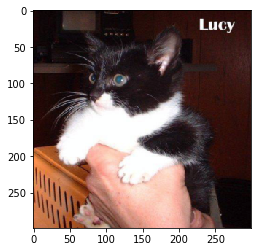

In [10]:
imshow(train_dset[90][0])

## Creating data loader for training and validation datasets

In [11]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating ResNet 34 model

In [12]:
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.to(device)

In [13]:
my_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Everthing except the fc Linear layer

In [14]:
m = nn.Sequential(*list(my_resnet.children())[:-1])

In [15]:
#use pretrained model
for p in m.parameters():
    p.requires_grad = False

## Extracting Convolutional features

In [16]:
#For training data

# Stores the labels of the train data
trn_labels = [] 

# Stores the pre convoluted features of the train data
trn_features = [] 

first=True
#Iterate through the train data and store the calculated features and the labels
for d,la in train_loader:
    o = m(Variable(d.to(device)))
    if first:
        print(f'in shape: {d.shape}, out shape: {o.shape}')
    o = o.view(o.size(0),-1)
    if first:
        print(f'out shape post flatten: {o.shape}')
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)
    first = False

#For validation data

#Iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d,la in val_loader:
    o = m(Variable(d.to(device)))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

in shape: torch.Size([32, 3, 299, 299]), out shape: torch.Size([32, 512, 4, 4])
out shape post flatten: torch.Size([32, 8192])


In [31]:
val_labels[0], val_features[0], val_features[0].shape

(tensor(0),
 tensor([2.3767, 2.2537, 1.8769,  ..., 0.8744, 0.7241, 0.6381]),
 torch.Size([8192]))

## Creating train and validation feature dataset

In [17]:
#Creating dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

#Creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [18]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [19]:
fc_in_size = 8192

In [20]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.to(device)

In [21]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and validate the model

In [22]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/walle/miniconda3/envs/pytorch1_py37/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.52 and training accuracy is 17170/23000      74.0
validation loss is  0.47 and validation accuracy is 1555/2000      77.0
training loss is  0.37 and training accuracy is 19674/23000      85.0
validation loss is  0.35 and validation accuracy is 1734/2000      86.0
training loss is  0.31 and training accuracy is 20488/23000      89.0
validation loss is  0.29 and validation accuracy is 1815/2000      90.0
training loss is  0.26 and training accuracy is 21029/23000      91.0
validation loss is  0.27 and validation accuracy is 1794/2000      89.0
training loss is  0.24 and training accuracy is 21206/23000      92.0
validation loss is  0.23 and validation accuracy is 1851/2000      92.0
training loss is  0.21 and training accuracy is 21456/23000      93.0
validation loss is  0.22 and validation accuracy is 1864/2000      93.0
training loss is  0.19 and training accuracy is 21627/23000      94.0
validation loss is  0.21 and validation accuracy is 1843/2000      92.0
traini

In [23]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.16 and training accuracy is 21912/23000      95.0
validation loss is  0.17 and validation accuracy is 1888/2000      94.0
training loss is  0.15 and training accuracy is 21948/23000      95.0
validation loss is  0.17 and validation accuracy is 1873/2000      93.0
training loss is  0.14 and training accuracy is 22026/23000      95.0
validation loss is  0.16 and validation accuracy is 1892/2000      94.0
training loss is  0.13 and training accuracy is 22133/23000      96.0
validation loss is  0.15 and validation accuracy is 1899/2000      94.0
training loss is  0.13 and training accuracy is 22154/23000      96.0
validation loss is  0.15 and validation accuracy is 1908/2000      95.0
training loss is  0.12 and training accuracy is 22150/23000      96.0
validation loss is  0.16 and validation accuracy is 1886/2000      94.0
training loss is  0.12 and training accuracy is 22171/23000      96.0
validation loss is  0.14 and validation accuracy is 1908/2000      95.0
traini

In [24]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.11 and training accuracy is 22320/23000      97.0
validation loss is  0.13 and validation accuracy is 1915/2000      95.0
training loss is   0.1 and training accuracy is 22279/23000      96.0
validation loss is  0.13 and validation accuracy is 1909/2000      95.0
training loss is   0.1 and training accuracy is 22341/23000      97.0
validation loss is  0.12 and validation accuracy is 1914/2000      95.0
training loss is 0.096 and training accuracy is 22375/23000      97.0
validation loss is  0.11 and validation accuracy is 1922/2000      96.0
training loss is 0.092 and training accuracy is 22420/23000      97.0
validation loss is  0.13 and validation accuracy is 1913/2000      95.0
training loss is 0.093 and training accuracy is 22393/23000      97.0
validation loss is  0.12 and validation accuracy is 1917/2000      95.0
training loss is 0.088 and training accuracy is 22450/23000      97.0
validation loss is  0.11 and validation accuracy is 1920/2000      96.0
traini

In [25]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.08 and training accuracy is 22529/23000      97.0
validation loss is   0.1 and validation accuracy is 1926/2000      96.0
training loss is 0.079 and training accuracy is 22501/23000      97.0
validation loss is  0.13 and validation accuracy is 1895/2000      94.0
training loss is 0.078 and training accuracy is 22513/23000      97.0
validation loss is  0.11 and validation accuracy is 1921/2000      96.0
training loss is 0.075 and training accuracy is 22541/23000      98.0
validation loss is 0.095 and validation accuracy is 1929/2000      96.0
training loss is 0.072 and training accuracy is 22566/23000      98.0
validation loss is  0.15 and validation accuracy is 1888/2000      94.0
training loss is 0.073 and training accuracy is 22541/23000      98.0
validation loss is 0.093 and validation accuracy is 1936/2000      96.0
training loss is  0.07 and training accuracy is 22566/23000      98.0
validation loss is 0.093 and validation accuracy is 1933/2000      96.0
traini

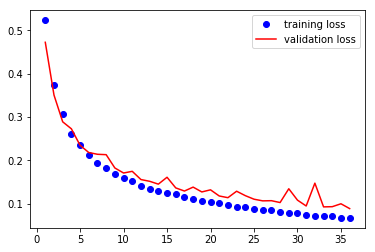

In [26]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()